<h3> OverView </h3>

Here in this case study we have to get the time when earthquake will occur
Our goal is to predict the time remaining before the next laboratory earthquake.
this experiment is performed in laboratory and data is captured 



* The goal of the challenge is to capture the physical state of the laboratory fault and how close it is from failure from a snapshot of the seismic data it is emitting. You will have to build a model that predicts the time remaining before failure from a chunk of seismic data, like we have done in our first paper above on easier data.

* The input is a chunk of 0.0375 seconds of seismic data (ordered in time), which is recorded at 4MHz, hence 150'000 data points, and the output is time remaining until the following lab earthquake, in seconds.

* The seismic data is recorded using a piezoceramic sensor, which outputs a voltage upon deformation by incoming seismic waves. The seismic data of the input is this recorded voltage, in integers.

* Both the training and the testing set come from the same experiment. There is no overlap between the training and testing sets, that are contiguous in time.

* Time to failure is based on a measure of fault strength (shear stress, not part of the data for the competition). When a labquake occurs this stress drops unambiguously.

* The data is recorded in bins of 4096 samples. Withing those bins seismic data is recorded at 4MHz, but there is a 12 microseconds gap between each bin, an artifact of the recording device.

Reference:
<a href="https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/77526" style="color:red">addition information discussion</a>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
# import dask.dataframe as dd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy import stats
from joblib import Parallel, delayed

from tqdm import tqdm_notebook as tqdm
import gc
from scipy.io import wavfile #convert dataframe to sound 
from IPython.core.display import HTML
from sklearn.metrics import mean_absolute_error
import librosa
# import shap
from sklearn.externals import joblib 
from tsfresh.feature_extraction import feature_calculators

/home/yatindma11/.local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#code copied form geekforgeeks.com
#calling garbage collector to clear the ram //if auto gc is taking time to run 
def garbageCollection():
    collected = gc.collect() 
    print("Garbage collector: collected","%d objects." % collected)

<h3> Reading Data </h3>

In [3]:
#loading the data
%time data = pd.read_csv('train.csv',dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

CPU times: user 2min 19s, sys: 17.2 s, total: 2min 37s
Wall time: 3min 42s


In [4]:
data.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [5]:
################# Run this for EDA only ###############
train_data_small = data.iloc[:582999]

# EDA on Data 

<b> Listning the earthquake </b>

In [6]:
# constant for sampling frequency
AUDIO_RATE = 55000
# amplification constant - so the sound is a bit louder
AMP_CONST = 141
# adding "volume channel" to dataframe
train_data_small["v"] = train_data_small.acoustic_data * AMP_CONST


# take a sub-sample from initial dataframe
START = 1
END = 582910
samp = train_data_small.iloc[START:END]


# creating audiowave and writing into a file
wave = (samp.v.values).astype("int16")
wavfile.write("sound.wav", AUDIO_RATE, wave)


from IPython.display import Audio
Audio('sound.wav')

* from the sound we can hear the stress given to material to produce earthquake

5009

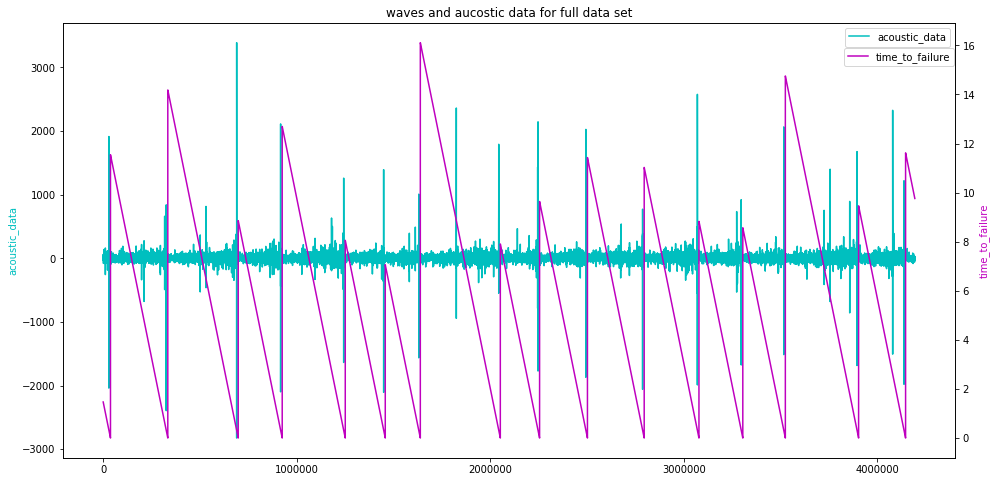

In [9]:
#code is copied from kaggle.com/
# graph of data
train_acoustic_data_small = data['acoustic_data'].values[::150]
train_time_to_failure_small = data['time_to_failure'].values[::150]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("waves and aucostic data for full data set")
plt.plot(train_acoustic_data_small, color='c')
ax1.set_ylabel('acoustic_data', color='c')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='m')
ax2.set_ylabel('time_to_failure', color='m')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small
gc.collect()

1. This graph show that after every bug hike in acoustic data earthquake occured
2. Both the data changin with time
3. There are total 17 earth quake occured in total train data set 
4. average earth quake time is 10 seconds (approximate)

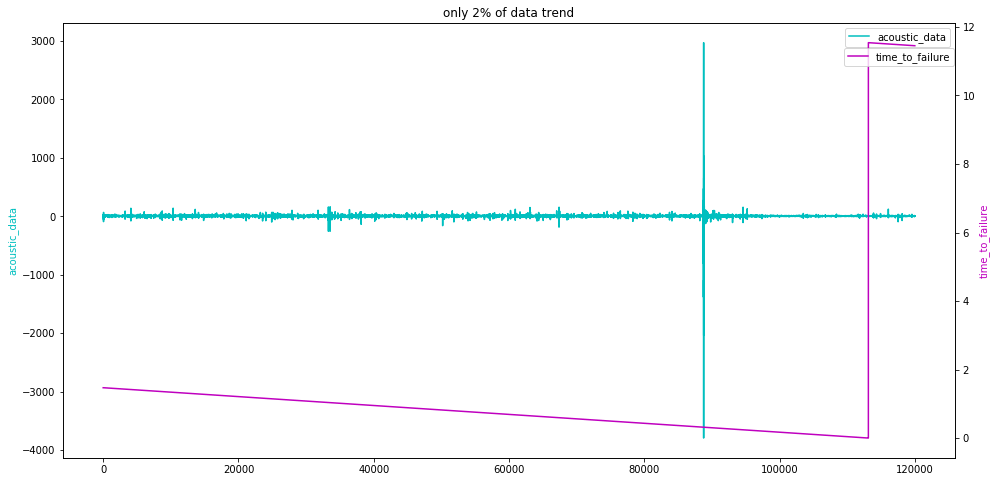

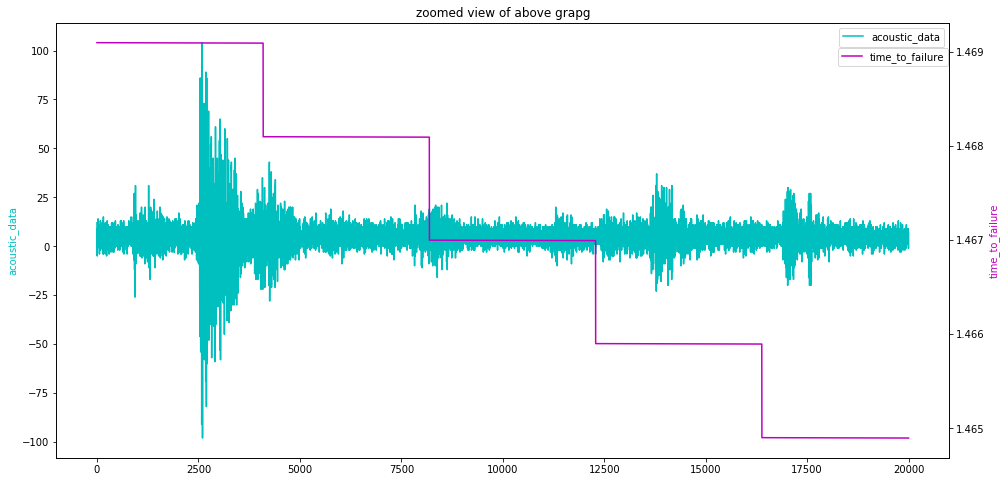

In [23]:
train_acoustic_data_small = data['acoustic_data'].values[:6000000:50]
train_time_to_failure_small = data['time_to_failure'].values[:6000000:50]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("only 2% of data trend")
plt.plot(train_acoustic_data_small, color='c')
ax1.set_ylabel('acoustic_data', color='c')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='m')
ax2.set_ylabel('time_to_failure', color='m')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small



train_acoustic_data_small = data['acoustic_data'].values[0:20000]
train_time_to_failure_small = data['time_to_failure'].values[0:20000]

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("zoomed view of above grapg")
plt.plot(train_acoustic_data_small, color='c')
ax1.set_ylabel('acoustic_data', color='c')
plt.legend(['acoustic_data'])
ax2 = ax1.twinx()
plt.plot(train_time_to_failure_small, color='m')
ax2.set_ylabel('time_to_failure', color='m')
plt.legend(['time_to_failure'], loc=(0.875, 0.9))
plt.grid(False)

del train_acoustic_data_small
del train_time_to_failure_small

1. This graph explain us when ever there is a hike in acoustic data then just after that earth quake occured // so we can predict from acoustic data

2. TTF is slowing down very slowly but linearly

3. first time to failure reach to zero then only earthquake occur

4. 2nd graph is showing the pattern how the quake time is reducing

5. In 2nd graph  we can see that each fall down taking nearly 10 microseconds 

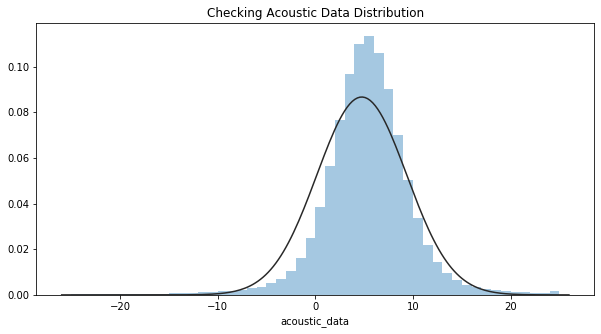

In [25]:
############## this will change to train_data ##################
import seaborn as sb
train_sample = train_data_small 
plt.figure(figsize=(10,5))
plt.title("Checking Acoustic Data Distribution")
tmp = train_sample.acoustic_data[train_sample.acoustic_data.between(-25, 25)]
ax = sb.distplot(tmp, label='2% Train data', kde=False, fit=stats.norm)




* This shows that data is not fully gaussianly distributed, there are some outliers in the data.
here black line denotes the gaussian distribution,

<b> Reading the data here </b>

<b> we have to add random noise to the data to make our model robust </b>

<b><font color="#ff0000">FFT don't represent abrupt changes in data efficiently </font></b>-> cz it represnt data as sum of sin waves which are not localized in time and space <br> <br>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/0a/MorletWaveletMathematica.svg/360px-MorletWaveletMathematica.svg.png" alt="Trulli" width="400" height="200">


To see the abrupt changes signal we need to use some function that are well localized for time and frequency -> <br> <b> <font color="#ff0000">wavelet</font> </b> <br>
wavelet are decaying wave like occilation that have <b>zero mean</b> <br>
wavelet exist for a <b>finite duration</b> <br> 
<b>streched wavelet</b> heped in getting <b>slowly varing changes in the frequency</b><br>
<b>flattened wavelet</b> help in getting <b>abupt varing changes</b> in the frequency<br>


# divide the data into train and CV

In [5]:
#code copied from https://stackoverflow.com/questions/6811183/rolling-window-for-1d-arrays-in-numpy
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [6]:

import pywt
noise = np.random.normal(0,0.5,150000)


def denoise_signal(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    
    sigma = (1/0.6745) * np.mean(np.absolute(coeff[-level] - np.mean(coeff[-level])))
    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    return pywt.waverec(coeff, wavelet, mode='per')





def denoising_the_signal(data): #data here is the acoustic data 
    new_data = data * 1.0
    new_data += noise #adding noise to the data
    new_data -= np.median(new_data) # subtracting the median // we are not choosing mean as in data mean can be curropted due to one wrong value hence median is more robust
    return denoise_signal(new_data)



def denoise_signal_simple(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    #univeral threshold
    uthresh = 10
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec(coeff, wavelet, mode='per')
  


def denoising_the_signal_simple(data): #data here is the acoustic data 
    new_data = data * 1.0
    new_data += noise  #adding noise to the data
    new_data -= np.median(data) # subtracting the median // we are not choosing mean as in data mean can be curropted due to one wrong value hence median is more robust
    return denoise_signal_simple(new_data)




# Mel Frequency Cepstral Coefficents (MFCCs)</b> are a feature widely used in <b>automatic speech and speaker recognition.

# data contain noise also 
#Mel-frequency cepstral coefficients (MFCCs)
# data contain noise also 
#Mel-frequency cepstral coefficients (MFCCs)


# Adding noise to make model more robust to noises
def cepstral(data,segment_data):
    new_data = data
    data += noise
    mfcc = librosa.feature.mfcc(data)
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_denoise_simple = librosa.feature.mfcc(new_data)
    mfcc_mean_denoise_simple = mfcc_denoise_simple.mean(axis=1) #0-19
    lib_spectral_contrast = librosa.feature.spectral_contrast(new_data).mean(axis=1) #0-6
    return (mfcc_mean_denoise_simple,lib_spectral_contrast)

In [7]:
from sklearn.preprocessing import normalize
# from tsfresh.feature_extraction import feature_calculators

def featurizing(df):
    global type_
    x = pd.DataFrame(index=[0], dtype=np.float64)
    #normal FEatures
    x['quantile_99'+type_] = np.quantile(df, 0.99)
    x['abs_quant_95'+type_] = np.quantile(np.abs(df), 0.95)

    
    #Rolling windows Percentile
    x['kurt'+type_]= np.percentile(pd.Series(df).rolling(100).kurt().dropna().values, 50)
    x['std'+type_]  = np.percentile(pd.Series(df).rolling(100).std().dropna().values, 50)
    x['mean'+type_] = np.percentile(pd.Series(df).rolling(100).mean().dropna().values, 50)
    x['skew'+type_] = np.percentile(pd.Series(df).rolling(100).skew().dropna().values, 50)
    x['max'+type_]  = np.percentile(pd.Series(df).rolling(100).max().dropna().values, 50)
    
    
    #Rolling window Quantile
    x['kurt'+type_]= np.quantile(pd.Series(df).rolling(100).kurt().dropna().values, .50)
    x['std'+type_]  = np.quantile(pd.Series(df).rolling(100).std().dropna().values, .50)
    x['mean'+type_] = np.quantile(pd.Series(df).rolling(100).mean().dropna().values, .50)
    x['skew'+type_] = np.quantile(pd.Series(df).rolling(100).skew().dropna().values, .50)
    x['max'+type_]  = np.quantile(pd.Series(df).rolling(100).max().dropna().values, .50)
    
    
#     # FFT features
    real_fft = np.real(df)
    x['fft_percentile_max'+type_] = np.quantile(pd.Series(real_fft).rolling(1000).max().dropna().values,.50)
    x['fft_min'+type_] = np.quantile(pd.Series(real_fft).rolling(1000).min().dropna().values,.50)
    x['fft_std'+type_] = np.quantile(pd.Series(real_fft).rolling(1000).std().dropna().values,.50)
    
    
    local_mean = pd.Series(real_fft).rolling(1000).mean().dropna()
    x['fft_mean_1'+type_]  = np.quantile(local_mean,.1)
    x['fft_mean_5'+type_]  = np.quantile(local_mean,.5)
    x['fft_mean_10'+type_] = np.quantile(local_mean,.10)
    x['fft_mean_25'+type_] = np.quantile(local_mean,.25)
    x['fft_mean_50'+type_] = np.quantile(local_mean,.50)
    x['fft_mean_95'+type_] = np.quantile(local_mean,.95)
    x['fft_mean_99'+type_] = np.quantile(local_mean,.99)  
      
    x['fft_percentile_max'+type_] = np.percentile(pd.Series(real_fft).rolling(1000).max().dropna().values,50)
    x['fft_percentile_min'+type_] = np.percentile(pd.Series(real_fft).rolling(1000).min().dropna().values,50)
    x['fft_percentile_std'+type_] = np.percentile(pd.Series(real_fft).rolling(1000).std().dropna().values,50)
    
    
    local_mean = pd.Series(real_fft).rolling(1000).mean().dropna()
    x['fft_percentile_mean_1'+type_]  = np.percentile(local_mean,1)
    x['fft_percentile_mean_5'+type_]  = np.percentile(local_mean,5)
    x['fft_percentile_mean_10'+type_] = np.percentile(local_mean,10)
    x['fft_percentile_mean_25'+type_] = np.percentile(local_mean,25)
    x['fft_percentile_mean_50'+type_] = np.percentile(local_mean,50)
    x['fft_percentile_mean_95'+type_] = np.percentile(local_mean,95)
    x['fft_percentile_mean_99'+type_] = np.percentile(local_mean,99) 
    
    #This is calculated using wavelet 
    denoising_the_signal_ = denoising_the_signal(df) * 1.0
    denoised_acoustic_data_simple_ = denoising_the_signal_simple(df) * 1.0
    cepstral_data = cepstral((denoising_the_signal_),df)
    
    
    
    # cepstral[0] matlb mfcc
    # cepstral[1] matlb lib


    

    
    
    
    x['mfcc_0'+type_] = (cepstral_data[0])[0] 
    x['mfcc_1'+type_] = (cepstral_data[0])[1]
    x['mfcc_2'+type_] = (cepstral_data[0])[2]
    x['mfcc_3'+type_] = (cepstral_data[0])[3] 
    x['mfcc_4'+type_] = (cepstral_data[0])[4] 
    x['mfcc_5'+type_] = (cepstral_data[0])[5]
    x['mfcc_6'+type_] = (cepstral_data[0])[6] 
    x['mfcc_7'+type_] = (cepstral_data[0])[7]
    x['mfcc_8'+type_] = (cepstral_data[0])[8] 
    x['mfcc_9'+type_] = (cepstral_data[0])[9] 
    x['mfcc_10'+type_] =(cepstral_data[0])[10]
    x['mfcc_11'+type_] = (cepstral_data[0])[11] 
    x['mfcc_12'+type_] = (cepstral_data[0])[12] 
    x['mfcc_13'+type_] = (cepstral_data[0])[13] 
    x['mfcc_14'+type_] = (cepstral_data[0])[14] 
    x['mfcc_15'+type_] = (cepstral_data[0])[15] 
    x['mfcc_16'+type_] = (cepstral_data[0])[16] 
    x['mfcc_17'+type_] = (cepstral_data[0])[17] 
    x['mfcc_18'+type_] = (cepstral_data[0])[18] 
    x['mfcc_19'+type_] = (cepstral_data[0])[19] 
    
    x['mfcc_mean'+type_] = np.mean(cepstral_data[0])
    
#     #Later added
    x['spectrum_denoised_2'+type_] = (cepstral_data[1])[2]
    x['spectrum_denoised_mean'+type_] = np.mean(cepstral_data[1])
    x['winner_NN_zero_crossings_denoise'+type_] = len(np.where(np.diff(np.sign(denoising_the_signal_)))[0])

    
    # experiment same like fft features
    x['denoised_max'+type_] = np.quantile(pd.Series(denoising_the_signal_).rolling(100).max().dropna().values,.50)
    x['denoised_min'+type_] = np.quantile(pd.Series(denoising_the_signal_).rolling(100).min().dropna().values,.50)
    x['denoised_std'+type_] = np.quantile(pd.Series(denoising_the_signal_).rolling(100).std().dropna().values,.50) 
    
    
    #Top features from discussion
    
    x['peaks'+type_] = feature_calculators.number_peaks(denoising_the_signal_, 10)
    x['autocorrelation'+type_] = feature_calculators.autocorrelation(denoising_the_signal_, 5)

    return x





In [8]:
indices_to_calculate = data.index.values[::150_000][:-1]

In [9]:
from tqdm import tqdm

####### train Feature Engineering ##########
def parse_sample(sample, start):
    global type_
    
    if type_ == "":
        delta = featurizing(sample['acoustic_data'].values)
        delta['start'] = start
        delta['target'] = sample['time_to_failure'].values[-1]
        return delta
    else:
        delta = featurizing(sample['acoustic_data'][::-1].values)   
        delta['start'] = start
        return delta
    
def sample_train_gen(df, segment_size=150_000, indices_to_calculate=[0]):
    global type_
    result = Parallel(n_jobs=-11, temp_folder="/tmp", max_nbytes=None, backend="multiprocessing")(delayed(parse_sample)(df[int(i) : int(i) + segment_size], int(i)) 
                                                                                                for i in tqdm(indices_to_calculate))
    data = [r.values for r in result]
    data = np.vstack(data)
    X = pd.DataFrame(data, columns=result[0].columns)
    X = X.sort_values("start")
    return X


############ TEST Feature Engineering ###########

def parse_sample_test(seg_id):
    sample = pd.read_csv('test/' + seg_id + '.csv', dtype={'acoustic_data': np.int32})
    if type_ == "":
        delta = featurizing(sample['acoustic_data'].values)
    else:
        delta = featurizing(sample['acoustic_data'].values[::-1])
    return delta

def sample_test_gen():
    count = 0
    X = pd.DataFrame()
    submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
    sub = submission.index
    result = Parallel(n_jobs=1, temp_folder="/tmp", max_nbytes=None, backend="multiprocessing")(delayed(parse_sample_test)(seg_id) for seg_id in tqdm(sub))
    data = [r.values for r in result]
    data = np.vstack(data)
    X = pd.DataFrame(data, columns=result[0].columns)
    return X




In [10]:
import pickle
#################### Train ####################
type_ = ""
train = sample_train_gen(data, indices_to_calculate=indices_to_calculate)
gc.collect()

with open('train_data', 'wb') as handle:
    pickle.dump(train, handle, protocol=pickle.HIGHEST_PROTOCOL)  

type_ = "_opp"
train_opp = sample_train_gen(data, indices_to_calculate=indices_to_calculate)
gc.collect()

with open('train_data_opp', 'wb') as handle:
    pickle.dump(train_opp, handle, protocol=pickle.HIGHEST_PROTOCOL) 

#################### Test ####################
type_ = ""
test = sample_test_gen()
gc.collect()

with open('test_data', 'wb') as handle:
    pickle.dump(test, handle, protocol=pickle.HIGHEST_PROTOCOL) 


type_ = "_opp"
test_opp = sample_test_gen()
gc.collect()

with open('test_data_opp', 'wb') as handle:
    pickle.dump(test_opp, handle, protocol=pickle.HIGHEST_PROTOCOL) 

100%|██████████| 2624/2624 [06:54<00:00,  6.33it/s]


In [11]:
import pickle
with open('test_data', 'rb') as f:
    test_old = pickle.load(f)
    
import pickle
with open('test_data_opp', 'rb') as f:
    test_opp_old = pickle.load(f)

import pickle
with open('train_data', 'rb') as f:
    train_old = pickle.load(f)
    
import pickle
with open('train_data_opp', 'rb') as f:
    train_opp_old = pickle.load(f)



In [19]:
train_opp = train_opp.drop('start',axis =1)
train = train.drop('start',axis =1)s

In [ ]:
arr = ['quantile_99_opp','abs_quant_95_opp','kurt_opp','std_opp','mean_opp','skew_opp','max_opp','fft_max_opp','fft_min_opp','fft_std_opp','fft_mean_1_opp','fft_mean_5_opp','fft_mean_10_opp','fft_mean_25_opp','fft_mean_50_opp','fft_mean_95_opp','fft_mean_99_opp']
train_opp=train_opp.drop(arr,axis=1)
train = train.drop('start',axis=1)
train_opp = train_opp.drop('start',axis=1)

#test_data
arr = ['quantile_99_opp','abs_quant_95_opp','kurt_opp','std_opp','mean_opp','skew_opp','max_opp','fft_max_opp','fft_min_opp','fft_std_opp','fft_mean_1_opp','fft_mean_5_opp','fft_mean_10_opp','fft_mean_25_opp','fft_mean_50_opp','fft_mean_95_opp','fft_mean_99_opp']
test_opp=test_opp.drop(arr,axis=1)

In [24]:
test_final = pd.concat([test,test_opp],axis =1)

In [25]:
train_final = pd.concat([train,train_opp],axis =1)

In [47]:
with open('x_train', 'wb') as handle:
    pickle.dump(train_final, handle, protocol=pickle.HIGHEST_PROTOCOL)  
    
with open('y_train', 'wb') as handle:
    pickle.dump(train_y, handle, protocol=pickle.HIGHEST_PROTOCOL)  
    
with open('x_test', 'wb') as handle:
    pickle.dump(test_final, handle, protocol=pickle.HIGHEST_PROTOCOL)  

<h3>References:</h3> <br>
<a href="https://blog.minitab.com/blog/adventures-in-statistics-2/how-to-interpret-regression-analysis-results-p-values-and-coefficients" style="color:red">p value for features importance</a>
 <br>
<a href="https://youtu.be/zOjHC5AtUjs" style="color:red">Regarding cepstrum </a><br>
<a href="https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/94888" style="color:red">Kaggle Discussion </a><br>
<a href="https://www.kaggle.com/" style="color:red"> Kaggle </a> <br>


